# Location Charts

Shot charts are a valuable resource for those analyzing a player or team. They can reveal tendencies, strengths, or weaknesses in a plan of attack. The same can be said for foul and assist charts.

The following explores the `Player` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `shortchartdetail` and `playerdashptpass` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to build charts that visualize shooting, fouling, and passing data.

## Shot Charts

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time

from py_ball import player, playbyplay

HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:
- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)

In [28]:
league_id = '00' #NBA
player_id = '0' #All players
game_id = '0021900111'
season = '2019-20'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900111,8,202339,Eric Bledsoe,1610612749,Milwaukee Bucks,1,11,35,...,Right Side Center(RC),24+ ft.,24,81,236,1,1,20191106,LAC,MIL
1,Shot Chart Detail,0021900111,11,202083,Wesley Matthews,1610612749,Milwaukee Bucks,1,11,10,...,Right Side Center(RC),24+ ft.,25,217,142,1,0,20191106,LAC,MIL
2,Shot Chart Detail,0021900111,13,101150,Lou Williams,1610612746,LA Clippers,1,10,56,...,Right Side(R),8-16 ft.,8,82,17,1,0,20191106,LAC,MIL
3,Shot Chart Detail,0021900111,18,202339,Eric Bledsoe,1610612749,Milwaukee Bucks,1,10,49,...,Left Side(L),24+ ft.,22,-225,16,1,0,20191106,LAC,MIL
4,Shot Chart Detail,0021900111,20,201976,Patrick Beverley,1610612746,LA Clippers,1,10,38,...,Center(C),Less Than 8 ft.,1,11,1,1,0,20191106,LAC,MIL
5,Shot Chart Detail,0021900111,22,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,10,27,...,Left Side(L),8-16 ft.,13,-131,11,1,0,20191106,LAC,MIL
6,Shot Chart Detail,0021900111,24,101150,Lou Williams,1610612746,LA Clippers,1,10,14,...,Center(C),Less Than 8 ft.,1,13,2,1,0,20191106,LAC,MIL
7,Shot Chart Detail,0021900111,27,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,10,9,...,Center(C),Less Than 8 ft.,1,-13,14,1,0,20191106,LAC,MIL
8,Shot Chart Detail,0021900111,30,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,10,7,...,Center(C),Less Than 8 ft.,0,2,4,1,1,20191106,LAC,MIL
9,Shot Chart Detail,0021900111,79,203507,Giannis Antetokounmpo,1610612749,Milwaukee Bucks,1,9,41,...,Center(C),Less Than 8 ft.,2,19,9,1,0,20191106,LAC,MIL


In [27]:
shots.data.keys()

dict_keys(['Shot_Chart_Detail', 'LeagueAverages'])

The above shows shot information from a Rockets at Sixers on 1/21/19. This game will serve as an example for generating player and team shot charts. First, we'll need a function to generate a court visual.

In [ ]:
shot_df[shot_df['TEAM_NAME']=='Delaware Blue Coats'][['PLAYER_NAME', 'PLAYER_ID', 'TEAM_NAME']]

In [ ]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

In [ ]:
court, court_axis = draw_court()
court

With the court visualization, the next step is to write a function that plots shots for a given player or team.

In [ ]:
def plot_shot(shot_df, player_or_team, unit_id):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of shot chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        shot = shot_df[shot_df['TEAM_ID']==unit_id]
        court_axis.set_title(shot['TEAM_NAME'].iloc[0], fontsize=14)
    else:
        shot = shot_df[shot_df['PLAYER_ID']==unit_id]
        court_axis.set_title(shot['PLAYER_NAME'].iloc[0], fontsize=14)

    miss_df = shot[shot['SHOT_MADE_FLAG']==0]
    make_df = shot[shot['SHOT_MADE_FLAG']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['LOC_X'], make_df['LOC_Y'], 'ko', alpha=0.5, label='Make')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['LOC_X'], miss_df['LOC_Y'], 'kx', alpha=0.5, label='Miss')

    plt.legend(loc='upper right')
    plt.close()
    return court

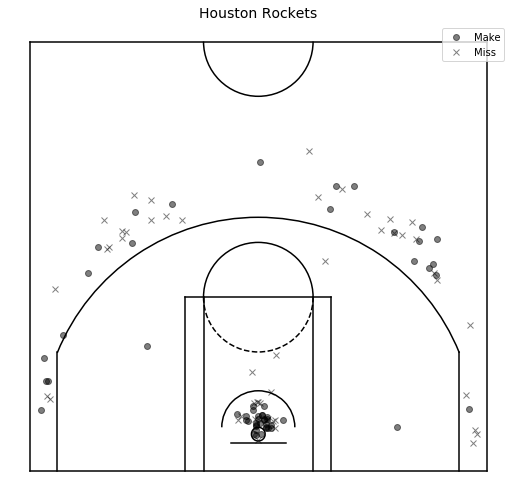

In [92]:
plot_shot(shot_df, 'team', 1610612745)

In [ ]:
plot_shot(shot_df, 'player', 203507)

The Sixers controlled the game, winning 121-93. The Rockets played to their gameplan by nearly eliminating the midrange shot from their repertoire, but the Sixers were able to get to the rim with regularity.

## Assist Charts

In [71]:
plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

play_df = pd.DataFrame(plays.data['PlayByPlay'])
play_df.head(35)

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG
0,0021900054,2,12,0,1,10:42 PM,12:00,None,None,None,...,None,None,0,0,None,NaN,None,None,None,0
1,0021900054,4,10,0,1,10:42 PM,12:00,Jump Ball McGee vs. Jackson Jr.: Tip to Crowder,None,None,...,Grizzlies,MEM,5,203109,Jae Crowder,1.610613e+09,Memphis,Grizzlies,MEM,1
2,0021900054,7,6,2,1,10:42 PM,11:44,Green S.FOUL (P1.T1) (B.Barnaky),None,None,...,Grizzlies,MEM,1,0,None,NaN,None,None,None,1
3,0021900054,9,3,11,1,10:43 PM,11:44,None,None,Valanciunas Free Throw 1 of 2 (1 PTS),...,None,None,0,0,None,NaN,None,None,None,1
4,0021900054,10,3,12,1,10:43 PM,11:44,None,None,Valanciunas Free Throw 2 of 2 (2 PTS),...,None,None,0,0,None,NaN,None,None,None,1
5,0021900054,11,2,43,1,10:43 PM,11:30,MISS McGee 2' Alley Oop Layup,None,None,...,None,None,0,0,None,NaN,None,None,None,1
6,0021900054,12,4,0,1,10:43 PM,11:26,None,None,Morant REBOUND (Off:0 Def:1),...,None,None,0,0,None,NaN,None,None,None,1
7,0021900054,13,2,41,1,10:43 PM,11:22,Davis BLOCK (1 BLK),None,MISS Morant 4' Running Layup,...,None,None,4,203076,Anthony Davis,1.610613e+09,Los Angeles,Lakers,LAL,1
8,0021900054,15,4,0,1,10:43 PM,11:22,None,None,Grizzlies Rebound,...,None,None,0,0,None,NaN,None,None,None,0
9,0021900054,17,1,47,1,10:44 PM,11:19,None,None,Brooks 9' Turnaround Jump Shot (2 PTS) (Crowde...,...,Grizzlies,MEM,0,0,None,NaN,None,None,None,1


In [72]:
list(play_df)

['GAME_ID',
 'EVENTNUM',
 'EVENTMSGTYPE',
 'EVENTMSGACTIONTYPE',
 'PERIOD',
 'WCTIMESTRING',
 'PCTIMESTRING',
 'HOMEDESCRIPTION',
 'NEUTRALDESCRIPTION',
 'VISITORDESCRIPTION',
 'SCORE',
 'SCOREMARGIN',
 'PERSON1TYPE',
 'PLAYER1_ID',
 'PLAYER1_NAME',
 'PLAYER1_TEAM_ID',
 'PLAYER1_TEAM_CITY',
 'PLAYER1_TEAM_NICKNAME',
 'PLAYER1_TEAM_ABBREVIATION',
 'PERSON2TYPE',
 'PLAYER2_ID',
 'PLAYER2_NAME',
 'PLAYER2_TEAM_ID',
 'PLAYER2_TEAM_CITY',
 'PLAYER2_TEAM_NICKNAME',
 'PLAYER2_TEAM_ABBREVIATION',
 'PERSON3TYPE',
 'PLAYER3_ID',
 'PLAYER3_NAME',
 'PLAYER3_TEAM_ID',
 'PLAYER3_TEAM_CITY',
 'PLAYER3_TEAM_NICKNAME',
 'PLAYER3_TEAM_ABBREVIATION',
 'VIDEO_AVAILABLE_FLAG']

In [73]:
play_df.loc[10]

GAME_ID                                                             0021900054
EVENTNUM                                                                    18
EVENTMSGTYPE                                                                 5
EVENTMSGACTIONTYPE                                                          45
PERIOD                                                                       1
WCTIMESTRING                                                          10:44 PM
PCTIMESTRING                                                             11:07
HOMEDESCRIPTION              James Out of Bounds - Bad Pass Turnover Turnov...
NEUTRALDESCRIPTION                                                        None
VISITORDESCRIPTION                                                        None
SCORE                                                                     None
SCOREMARGIN                                                               None
PERSON1TYPE                                         

By examining the above play, which includes an assisted basket, we see that the player credited with the assist is included in the play-by-play data through the `PLAYER2` fields. We can join this table to `shot_df` using the `EVENTNUM` field.

In [74]:
assist_df = shot_df.merge(play_df[['EVENTNUM',
                                  'HOMEDESCRIPTION',
                                  'VISITORDESCRIPTION',
                                  'PLAYER2_ID',
                                  'PLAYER2_NAME']], left_on='GAME_EVENT_ID', right_on='EVENTNUM')

In [75]:
assist_df = assist_df[pd.notnull(assist_df['PLAYER2_NAME'])]

In [76]:
assist_df.head(5).T

,2,4,5,9,11
GRID_TYPE,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail
GAME_ID,0021900054,0021900054,0021900054,0021900054,0021900054
GAME_EVENT_ID,17,22,24,34,38
PLAYER_ID,1628415,203076,1628991,1628991,1628415
PLAYER_NAME,Dillon Brooks,Anthony Davis,Jaren Jackson Jr.,Jaren Jackson Jr.,Dillon Brooks
TEAM_ID,1610612763,1610612747,1610612763,1610612763,1610612763
TEAM_NAME,Memphis Grizzlies,Los Angeles Lakers,Memphis Grizzlies,Memphis Grizzlies,Memphis Grizzlies
PERIOD,1,1,1,1,1
MINUTES_REMAINING,11,10,10,9,9
SECONDS_REMAINING,19,40,26,38,16


Nice! The table above shows that `PLAYER2_ID` corresponds to the player credited with the assist on all shots in the game. Now let's visualize these assists. Note, these locations are still the locations of the shot, not the location of the pass.

In [77]:
def plot_ast(ast_df, player_or_team, unit_id):
    """ plot_ast plots an assist or list of assists given in the
    assist DataFrame provided

    @param ast_df (DataFrame): DataFrame of assists with LOC_X and
        LOC_Y columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of assist chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the assists plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        ast = ast_df[ast_df['TEAM_ID']==unit_id]
        if len(ast)>0:
            court_axis.set_title(ast['TEAM_NAME'].iloc[0], fontsize=14)
    else:
        ast = ast_df[ast_df['PLAYER2_ID']==unit_id]
        if len(ast)>0:
            court_axis.set_title(ast['PLAYER2_NAME'].iloc[0], fontsize=14)


    if len(ast_df)>0:
        court_axis.plot(-ast['LOC_X'], ast['LOC_Y'], 'ko', alpha=0.5, label='Assist')

    plt.legend(loc='upper right')
    plt.close()
    return court

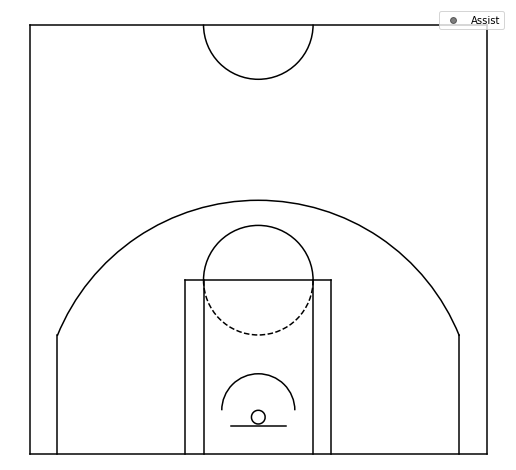

In [42]:
plot_ast(assist_df, 'team', 1612709909)

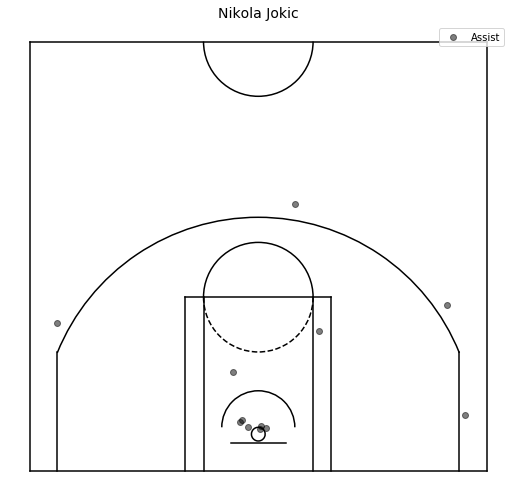

In [43]:
plot_ast(assist_df, 'player', 203999)

The Sixers also won the assist battle 21-14. The charts show that the Sixers were able to create more assisted three-point field goals than the Rockets.

## Shooting Fouls Drawn Chart

The ability to draw shooting fouls and get to the free throw line is an important aspect of offense. Because shot charts only include attempted shots, shooting fouls that do not result in a successful field goal are not shown. The shooting fouls drawn chart will provide more context to where and how a player is generating offense.

In [78]:
play_df.loc[14]

GAME_ID                                                             0021900054
EVENTNUM                                                                    24
EVENTMSGTYPE                                                                 1
EVENTMSGACTIONTYPE                                                           1
PERIOD                                                                       1
WCTIMESTRING                                                          10:45 PM
PCTIMESTRING                                                             10:26
HOMEDESCRIPTION                                                           None
NEUTRALDESCRIPTION                                                        None
VISITORDESCRIPTION           Jackson Jr. 27' 3PT Jump Shot (3 PTS) (Valanci...
SCORE                                                                    7 - 2
SCOREMARGIN                                                                 -5
PERSON1TYPE                                         

The play above is a shooting foul drawn by James Harden. Isolating these plays will be necessary for the shooting foul drawn charts, but the location of these fouls is also needed. Again, the `shotchartdetail` endpoint can be used with the `context_measure = 'PF'` to get these locations.

In [79]:
context_measure = 'PF'
fouls = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season,
                      context_measure=context_measure)
foul_df = pd.DataFrame(fouls.data['Shot_Chart_Detail'])
foul_df.head(15)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021900054,7,201980,Danny Green,1610612747,Los Angeles Lakers,1,11,44,...,Center(C),Less Than 8 ft.,2,3,24,1,0,20191029,LAL,MEM
1,Shot Chart Detail,0021900054,26,202340,Avery Bradley,1610612747,Los Angeles Lakers,1,10,18,...,Center(C),8-16 ft.,11,-1,116,1,0,20191029,LAL,MEM
2,Shot Chart Detail,0021900054,40,201980,Danny Green,1610612747,Los Angeles Lakers,1,9,16,...,Left Side Center(LC),24+ ft.,25,-205,152,1,0,20191029,LAL,MEM
3,Shot Chart Detail,0021900054,57,203076,Anthony Davis,1610612747,Los Angeles Lakers,1,7,47,...,Center(C),8-16 ft.,13,-64,117,1,0,20191029,LAL,MEM
4,Shot Chart Detail,0021900054,74,1628991,Jaren Jackson Jr.,1610612763,Memphis Grizzlies,1,6,33,...,Center(C),Less Than 8 ft.,2,15,21,1,0,20191029,LAL,MEM
5,Shot Chart Detail,0021900054,90,1628991,Jaren Jackson Jr.,1610612763,Memphis Grizzlies,1,5,40,...,Center(C),Less Than 8 ft.,3,2,32,1,0,20191029,LAL,MEM
6,Shot Chart Detail,0021900054,103,1628415,Dillon Brooks,1610612763,Memphis Grizzlies,1,4,55,...,Center(C),Less Than 8 ft.,6,-14,63,1,0,20191029,LAL,MEM
7,Shot Chart Detail,0021900054,116,2730,Dwight Howard,1610612747,Los Angeles Lakers,1,4,12,...,Left Side Center(LC),24+ ft.,25,-182,178,1,0,20191029,LAL,MEM
8,Shot Chart Detail,0021900054,129,203109,Jae Crowder,1610612763,Memphis Grizzlies,1,3,37,...,Center(C),16-24 ft.,18,43,176,1,0,20191029,LAL,MEM
9,Shot Chart Detail,0021900054,143,203937,Kyle Anderson,1610612763,Memphis Grizzlies,1,2,21,...,Center(C),Less Than 8 ft.,6,-19,59,1,0,20191029,LAL,MEM


Shooting fouls can be isolated from the play-by-play data by subsetting on the conditions `EVENTMSGTYPE == 6` and `EVENTMSGACTIONTYPE == 2`. Once these plays are isolated, they can be inner-joined to the `foul_df` above to get the locations of all shooting fouls in the game.

In [80]:
shooting_plays_df = play_df[(play_df['EVENTMSGTYPE']==6) & (play_df['EVENTMSGACTIONTYPE']==2)]

In [81]:
shooting_foul_df = foul_df.merge(shooting_plays_df[['EVENTNUM',
                                                    'HOMEDESCRIPTION',
                                                    'VISITORDESCRIPTION',
                                                    'PLAYER2_ID',
                                                    'PLAYER2_NAME',
                                                    'PLAYER2_TEAM_ID',
                                                    'PLAYER2_TEAM_NICKNAME',
                                                    'PLAYER2_TEAM_CITY']],
                                 left_on='GAME_EVENT_ID', right_on='EVENTNUM')

In [82]:
shooting_foul_df.head(5).T

,0,1,2,3,4
GRID_TYPE,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail,Shot Chart Detail
GAME_ID,0021900054,0021900054,0021900054,0021900054,0021900054
GAME_EVENT_ID,7,40,57,74,90
PLAYER_ID,201980,201980,203076,1628991,1628991
PLAYER_NAME,Danny Green,Danny Green,Anthony Davis,Jaren Jackson Jr.,Jaren Jackson Jr.
TEAM_ID,1610612747,1610612747,1610612747,1610612763,1610612763
TEAM_NAME,Los Angeles Lakers,Los Angeles Lakers,Los Angeles Lakers,Memphis Grizzlies,Memphis Grizzlies
PERIOD,1,1,1,1,1
MINUTES_REMAINING,11,9,7,6,5
SECONDS_REMAINING,44,16,47,33,40


In [83]:
def plot_foul(foul_df, player_or_team, unit_id):
    """ plot_foul plots a foul or list of fouls given in the
    foul DataFrame provided

    @param foul_df (DataFrame): DataFrame of fouls with LOC_X and
        LOC_Y columns

    @param player_or_team (str): One of 'team' or 'player'
        strings indicating the type of foul chart to generate

    @param unit_id (int): Unique identifier of player or team

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the fouls plotted
    """
    court, court_axis = draw_court()
    if player_or_team=='team':
        foul = foul_df[foul_df['PLAYER2_TEAM_ID']==unit_id]
        if len(foul)>0:
            court_axis.set_title(foul['PLAYER2_TEAM_CITY'].iloc[0] + \
                                 ' ' + foul['PLAYER2_TEAM_NICKNAME'].iloc[0], fontsize=14)
    else:
        foul = foul_df[foul_df['PLAYER2_ID']==unit_id]
        if len(foul)>0:
            court_axis.set_title(foul['PLAYER2_NAME'].iloc[0], fontsize=14)


    if len(foul_df)>0:
        court_axis.plot(-foul['LOC_X'], foul['LOC_Y'], 'ko', alpha=0.5, label='Shooting Foul Drawn')

    plt.legend(loc='upper right')
    plt.close()
    return court

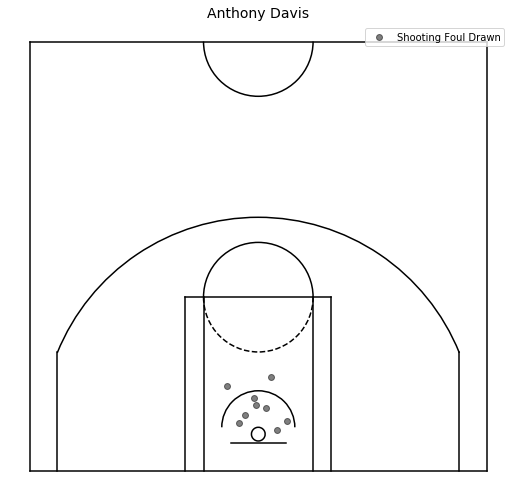

In [84]:
plot_foul(shooting_foul_df, 'player', 203076)

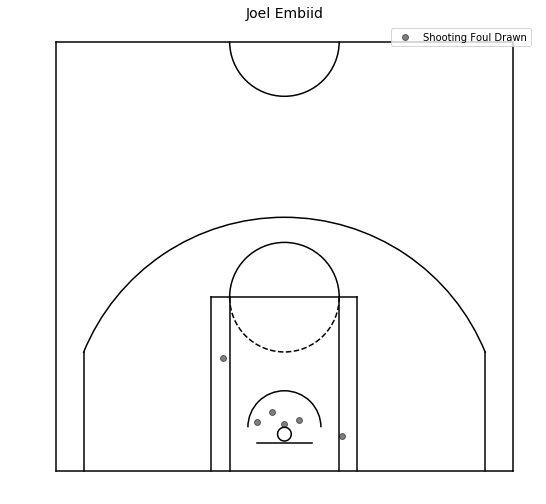

In [24]:
plot_foul(shooting_foul_df, 'player', 203954)

Joel Embiid and James Harden have a reputation for drawing fouls. This game does not refute that notion, with the foul charts showing six trips to the line for Joel Embiid and four for James Harden.

## Exploration

- The above charts show location data for a single team. Try to pull more data for a given team or player and generate visualizations that show longer-term trends in shooting or assist data.
- Explore the `PERSONXTYPE` field in the play-by-play data. This shows the position that a given player is playing at the time. Repeat the above exercise for a given position to visualize where PFs score or SGs field goals are assisted.